In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Walks for Finance Part 1: Introduction to Discrete Time Quantum Walks
$
\renewcommand{\ket}[1]{|{#1}\rangle}
\renewcommand{\bra}[1]{\langle{#1}|}
$

--- 
## Overview
This tutorial serves as an introduction to quantum walks, using the discrete time quantum walk as an example. It prepares you for the next tutorial, where we will apply quantum walks to a finance problem. You will learn about quantum walks by comparing them to classical random walks. By the end of the tutorial, you will have coded a variational discrete time quantum walk in CUDA-Q, setting the stage for exploring more advanced walking protocols and parameter optimization in the next notebook.

**What you'll do:**
* Review CUDA-Q programming syntax
* Compare classical random walks with a discrete time quantum walk
* Develop and implement a kernel with custom gates for a discrete time quantum walk along a line segment

**CUDA-Q syntax you'll use:**
* quantum kernel function decoration: `@cudaq.kernel`
* qubit initialization: `cudaq.qvector` and `cudaq.qubit`
* quantum gates: `x`, `h`, `t`, _`.ctrl`, `cudaq.register_operation` 
* execute a kernel: `sample`, `get_state`, _`.amplitude`
* visualize circuit structure of a kernel: `cudaq.draw`

**Pre-requisites:** Learners should have familiarity with Jupyter notebooks and programming in Python and CUDA-Q. It is assumed the reader has some familiarity already with quantum computation and is comfortable with braket notation and the concepts of qubits, quantum circuits, measurement, and circuit sampling. The CUDA-Q Academic course entitled "[Quick Start to Quantum Computing with CUDA-Q](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum)" provide a walkthrough of this prerequisite knowledge if the reader is new to quantum computing and CUDA-Q or needs refreshing.


First let's install the necessary packages.

In [ ]:
## Instructions for Google Colab. You can ignore this cell if you have cuda-q set up and have 
# all the dependent files on your system
# Run this notebook in a CPU runtime
# Uncomment the lines below and execute the cell to install cuda-q

#!pip install cudaq

#!wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
#!unzip -q main.zip
#!mv cuda-q-academic-main/quantum-applications-to-finance/images ./images

In [1]:
import cudaq
import numpy as np
import matplotlib.pyplot as plt

---
## CUDA-Q Basics

Let's start with a brief overview of CUDA-Q syntax, which will be utilized throughout this tutorial

### Defining quantum kernels and custom gates

Quantum kernels are functions that can be executed on quantum hardware, and in Python, these are marked with the `@cudaq.kernel` decorator.

For instance, you might want to create a quantum kernel that initializes a few qubits and applies specific gate operations to them.  CUDA-Q offers several pre-defined gates, which you can explore in detail [here](https://nvidia.github.io/cuda-quantum/latest/api/default_ops.html). As demonstrated in the following example, you can also define custom gate operations from a unitary matrix using the `register_operation` command.  Additionally, it is possible to create operators controlled by a control qubit.   

Let's see how to create a kernel in CUDA-Q.  We'll initialize 2 qubits in the zero state using `cudaq.qvector` and apply a bit flip gate followed by a custom $T$-gate to the first qubit and apply a Hadamard gate to the 2nd qubit, and a controlled $T$-gate between the two qubits. Here's how to define and visualize this kernel using `cudaq`:

In [2]:
# Define a quantum kernel with 2 qubits using built in gates, 
# a custom gate, and controlled gates

# Define a unitary matrix for the custom T gate
T = np.matrix([[1, 0], [0, np.exp(1j * np.pi / 4)]])

# Create a quantum gate operation for the matrix T and call it Tgate
cudaq.register_operation("Tgate", T)

@cudaq.kernel
def my_kernel():
    # Initialize the qubits
    qubits = cudaq.qvector(2)
    
    # Apply an x-gate followed by a t-gate to the first qubit
    x(qubits[0])
    Tgate(qubits[0]) # or alternatively use the cuda-q t-gate function: t(qubits[0])    
    
    # Apply a Hadamard gate to the second qubit
    h(qubits[1])
    
    # Apply a controlled-Tgate with control qubit 0 and target qubit 1
    Tgate.ctrl(qubits[0], qubits[1])
    

    
# Visualize the quantum kernel using circuit notation
print(cudaq.draw(my_kernel))

     ╭───╮╭───────╮         
q0 : ┤ x ├┤ Tgate ├────●────
     ├───┤╰───────╯╭───┴───╮
q1 : ┤ h ├─────────┤ Tgate ├
     ╰───╯         ╰───────╯



The kernel in the previous code block defined a quantum circuit, but we can also use kernels to define operations on qubits.  We'll see an example of this in the next section when we define the kernel `initial_position` which accepts as input a list of qubits with type `cudaq.qvector` (or`cudaq.qview`).

### Executing a quantum kernel

To get the state of the qubits after executing the kernel, we can either use `cudaq.sample` or `cudaq.get_state`:

In [ ]:
# Define the simulation target
cudaq.set_target("qpp-cpu")  # "nvidia" for simulation on a GPU 

# Sample the kernel and print the results
result = cudaq.sample(my_kernel, shots_count=1000)
print('The result of sampling the kernel with qubit ordering q0, q1 is:', result)

# Get the state of the kernel and print the statevector
state = cudaq.get_state(my_kernel)
precision = 4
print('The get_state command uses the default ordering \n00, 10, 01, 11 for listing the coefficients of the statevector:\n',np.round(np.array(state), precision))

The result of sampling the kernel with qubit ordering q0, q1 is: { 10:508 11:492 }

The get_state command uses the default ordering 
00, 10, 01, 11 for listing the coefficients of the statevector:
 [ 0. +0.j      0.5+0.5j     0. +0.j     -0. +0.7071j]


---
## Discrete Time Quantum Walks

This section will prepare us for [Quantum Walks for Finance Part 2](https://github.com/NVIDIA/cuda-q-academic/quantum-applications-to-finance/02_quantum_walks.ipynb), where we address the following problem:

> **Encoding Probability Distributions Problem**:  Given a discrete probability distribution $\mathcal{P}$, generate a quantum kernel (i.e., a sequence of quantum gates) that transforms an initial state into a final state whose measurement outcomes match the target distribution $\mathcal{P}$.

One approach to tackle this problem is through random walks by using a variational algorithm to search for the random walk that will generate a targeted distribution, as depicted in the animation below. 

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/refs/heads/main/images/quantum_walk_target.gif" width="600">

Before we tackle that problem, we need to define quantum random walks.  Let's first visualize a classical random walk along a number line generating a binomial distribution. You can imagine a walker moving left or right depending on the result of a coin flip.  The animation below shows the experiment of a walker making 4 moves based on 4 separate coin flips run several times.  

In [4]:
# Run this code to watch a short video demonstrating a random walk
# The green dot represents the walker whose movements are dictated by flips of a fair coin
# The ending position from each run of the experiment is recorded in the histogram
from IPython.display import Video

# Path to the MP4 file
video_path = "images/galton_board-coin.mp4"

# Display the video
Video(video_path, embed=True, width = 400)

Unlike classical random walks, where probabilities dictate movement, quantum walks rely on amplitudes. Interference between paths leads to a faster spread over the position space, making quantum walks useful for generating more complex probability distributions.  

We start this section by defining classical random walks and discrete-time quantum walks (DTQW). In the following section, we use CUDA-Q to encode an example of a DTQW into a CUDA-Q kernel. 

### Comparing Classical Random Walks with Discrete Time Quantum Walks 

Let's consider a discrete walk taking place on a line. In this scenario, we envision a walker progressing along the 
x-axis in discrete increments, with the movement governed by predefined rules based on coin flips.  A classical random walk can be viewed as a decision tree, as in the diagram below.  Here, a walker begins in the center of the line. After a coin flip, the walker moves to the left or right depending on the outcome of the coin flip (e.g., flipping heads will send the walker one step to the left, while flipping tails will send the walker one step to the right).  After $n$ coin flips, we record the position of the walker.  This experiment is repeated multiple times to generate a histogram of the walker's final position.

<img src="images/classical-walk.png" width="600">

A **discrete-time quantum walk (DTQW)** is the quantum analogue of a classical random walk. In this scenario, both the position of the walk and the coin are represented as quantum states, $\ket{\psi_W}$ and $\ket{\psi_C}$, respectively. Throughout this walk, the state of the walker changes according to quantum shift operators ($S_+, S_-$) which depend on the state of the coin $\ket{\psi_C}$. In particular, the $S_{-}$ operation checks if $\ket{\psi_C}$ in the state $\ket{0}$ (i.e., heads) and if so, induces a shift left operation $DEC$ on the quantum walker. Similarly, $S_{+}$ is defined for tails and shifting right. At each time step, the state of the coin changes (i.e., is "flipped") via a quantum operation ($F$), which we'll call the coin-flip operator. Unlike the classical random walk, we will not know the position of the walker until the end of the process, when the quantum state of the walker is measured. 

In the diagram below, we illustrate a 2-step quantum walk where the coin-flip operator $F$ is the Hadamard gate.  Notice how the final distribution of the walker's possible positions differs from the classical case.


<img src="images/dtqw-superposition-coin.png" width="600">


#### The Line that the Walker Traverses
 For our example, we consider a line that contains $16$ positions: $0,1,\cdots,15$ encoded with the computational basis states on $4$ qubits: $\ket{\bf{0}} = \ket{0000}, \ket{\bf{1}} = \ket{0001}, \ket{\bf{2}} = \ket{0010}, \cdots, \ket{\bf{15}} = \ket{1111}$.  In other words, the computational basis state $\ket{\bf{i}}$ represents the $i^{th}$ location on the line. 


#### The Walker's Position State
The walker's position after $t$ time steps is given by a linear combination of the computational basis states $$\ket{\psi_W} = \sum_{i}\alpha_i(t)\ket{\bf{i}},$$ for some $\alpha_i(t)\in\mathbb{C}$ satisfying $\sum_{i}|\alpha_i(t)|^2 = 1$.  For instance, if the walker began the experiment at position $0$, then the state of the walker at time $0$ would be $\ket{\psi_W(0)}=\ket{0000}$.  

More interestingly, the walker might begin the experiment in a superposition of two or more positions, as depicted in the figure below.  In this case, the walker's initial state is $\ket{\psi_W(0)}=\frac{1}{\sqrt{2}}\ket{0010}+\frac{1}{\sqrt{2}}\ket{0011}$. The aim of this section is to encode into CUDA-Q the first step of the discrete time quantum walk drawn below.

<img src="images/dtqw-superposition-walker.png" width="600">

### Programming a DTQW with CUDA-Q

Let's start coding up one step of the DTQW in CUDA-Q. The circuit diagram for this is the following: 

<img src="images/dtqw-one-step-diagram.png" width="600">

The first step is to edit the code block below to create a kernel that generates the walker's initial position state: $\ket{\psi_W(0)}=\frac{1}{\sqrt{2}}\ket{0010}+\frac{1}{\sqrt{2}}\ket{0011}$ using an `h` gate and CNOT gates `x.ctrl(control_qubit, target_qubit)`.

In [5]:
# EXERCISE 1
# Define a kernel that prepares the walker qubits in an
# equal superposition of the states |2> = |0010> and |3> = |0011>.

@cudaq.kernel
def initial_position(qubits : cudaq.qvector):
    """ Apply gates to the qubits to prepare the GHZ state
    Parameters
        qubits: cudaq.qvector
        qubits for the walker
    """
    
    # Edit the code below this line



    
    # Edit the code above this line

We can verify that our solution is correct by using the `cudaq.get_state` and _`.amplitudes` commands.  Additionally, in the code block below, we will create a helper function to graph the distribution of the walker's positions, as represented by the state.

Walker state array of coefficients: [0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j 0.7071+0.j 0.    +0.j
 0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j 0.    +0.j
 0.7071+0.j 0.    +0.j 0.    +0.j 0.    +0.j]
Walker statevector: (0.7071+0j) |0010> + (0.7071+0j) |0011>


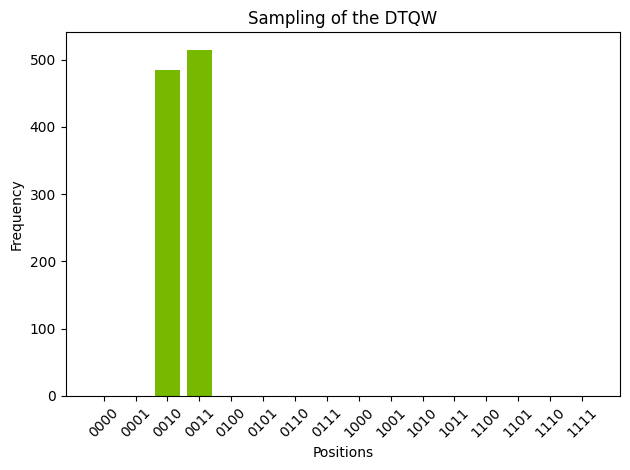

In [7]:
# Create a quantum kernel that initializes the state of the walker

num_qubits = 4

@cudaq.kernel
def walker(num_qubits : int):
    """ Kernel to initialize the state of the walker
    Parameters
        num_qubits : int
        Number of qubits for the walker
    """
    # Initialize the qubits
    qubits = cudaq.qvector(num_qubits)
    
    # Apply the initial state to the qubits
    initial_position(qubits)
    
# Get the state of the walker after applying the quantum kernel
state = cudaq.get_state(walker, 4)

# Return the amplitudes of |0010> and |0011>
state_amplitudes = state.amplitudes([[0,0,1,0], [0,0,1,1]])

# Print 
precision = 4
print('Walker state array of coefficients:', np.round(np.array(state), precision))
print('Walker statevector: {} |0010> + {} |0011>'.format(np.round(state_amplitudes[0],precision), np.round(state_amplitudes[1],precision)))

# Define a function to draw the histogram of the results 

def plot_results(result, num_qubits):
    # Define a dictionary of results 

    # Initialize the dictionary with all possible bit strings of length 4 for the x axis
    result_dictionary = {}

    # Generate all possible bit strings of length num_qubits
    for i in range(2**num_qubits):
        bitstr = bin(i)[2:].zfill(num_qubits)
        result_dictionary[bitstr] = 0

    # Update the results dictionary of results from the circuit sampling
    for k,v in result.items():
        result_dictionary[k] = v

    # Convert the dictionary to lists for x and y values
    x = list(result_dictionary.keys())

    y = list(result_dictionary.values())

    # Create the histogram
    plt.bar(x, y, color='#76B900')

    # Add title and labels
    plt.title("Sampling of the DTQW")
    plt.xlabel("Positions")
    plt.ylabel("Frequency")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()
    
results = cudaq.sample(walker, 4, shots_count =1000)
plot_results(results, num_qubits)

#### Walking the Line

The next step (no pun intended) is to define incrementer (`INC`) and decrementer (`DEC`) operations, which will change the state of the walker with shifts to the left and right on the number line, respectively.  We'll use these operations to build up the shift operators $S_-$ and $S_+$ which depend on the state of the coin.  First, let's define `INC` so that when applied to a basis state $\ket{x}$, the result is $\ket{(x+1)_{\mod{16}}}$ for $x\in \{0,\cdots 15\}$.  The unitary matrix below carries out this transformation:

\[ \begin{pmatrix} 0 & 0 & 0 & 0 & \cdots  \\ 
                        1 & 0 & 0 & 0 & \cdots \\
                        0 & 1 & 0 & 0 & \cdots \\
                        0 & 0 & 1 & 0 & \cdots \\
                        \vdots & \vdots & \vdots & \vdots & \ddots \end{pmatrix} \]

Using the `cudaq.register_operation` we can create a custom gate for this unitary matrix. The code block defines a `cudaq.kernel` to carry out the custom INC gate, and conducts a test to verify that the operation acts as expected on the zero state.  


In [8]:
# Define a custom operation on 4 qubits for the INC unitary matrix that
# maps |x> to |x+1> mod 16 and verify that it works as expected for |0000>

num_qubits = 4

# Define the incrementer matrix
def incrementer(num_qubits):
    size = 2**num_qubits
    inc_matrix = np.zeros((size, size))
    for i in range(size):
        inc_matrix[i, (i - 1) % size] = 1
    return inc_matrix

# Create a custom register operation for the incrementer
cudaq.register_operation("INC", incrementer(num_qubits))

@cudaq.kernel
def check_incrementer_kernel():
    qubits = cudaq.qvector(4)
    INC(qubits[0], qubits[1], qubits[2], qubits[3])

# Print the INC circuit
print(cudaq.draw(check_incrementer_kernel))

result = cudaq.sample(check_incrementer_kernel, shots_count=1000).most_probable()
print('Incrementer kernel |0000> -> |{}>'.format(result))

     ╭─────╮
q0 : ┤     ├
     │     │
q1 : ┤     ├
     │ INC │
q2 : ┤     ├
     │     │
q3 : ┤     ├
     ╰─────╯

Incrementer kernel |0000> -> |0001>


Using the fact that `DEC` is the inverse of `INC`, create a kernel for a custom `DEC` operation.

In [ ]:
# EXERCISE 2 

# Define a kernel on 4 qubits for the DEC operation that
# maps |x> to |x-1> mod 16 and verify that it works as expected for |0001>



# Define the decrementer matrix

def decrementer(num_qubits):
    size = 2**num_qubits
    dec_matrix = np.zeros((size, size))
    for i in range(size):
        dec_matrix[i, (i + 1) % size] = 1
    return dec_matrix


# EDIT THE CODE BELOW THIS LINE

# Create a custom register operation for the decrementer called DEC


# EDIT THE CODE ABOVE THIS LINE

# Create a kernel that applies the DEC to the 4-qubit state |0001>
@cudaq.kernel
def check_decrementer_kernel():
    qubits = cudaq.qvector(4)
    # Initialize the qubits to |0001>
    x(qubits[3])
    # Apply the decrementer operation 
    DEC(qubits[0], qubits[1], qubits[2], qubits[3])

result = cudaq.sample(check_decrementer_kernel, shots_count=1000).most_probable()
print('Decrementer kernel |0001> -> |{}>'.format(result))

### Avoiding Walking in Circles

It is important to note that, as currently outlined, we are on track to define a quantum walk that will allow a walker to move between positions $\ket{0}=\ket{0000}$ and $\ket{15}=\ket{1111}$ in one step.  This behavior might not be desired, for instance, in a financial application where the positions of the walker represent stock prices and movement is related to positive or negative investor sentiment. 

To prevent one-step transitions between $\ket{0}$ and $\ket{1}$ , we use an auxiliary qubit (`endpoint_qubit`), Toffoli gates, CNOT gates, and a mid-circuit `reset` to ensure a coin in the state $\ket{1}$ does not trigger a shift right (`INC`) when the walker is at $\ket{1111}$, and a coin in the state $\ket{0}$ does not trigger a shift left (`DEC`) when the walker is in the state $\ket{0000}$. This process is depicted below for one step of the DTQW:

<img src="images/DTQW_endpoint.png" width="600">

The corresponding functions to prevent one-step transitions between $\ket{0000}$ and $\ket{1111}$ are defined below.

In [11]:
# Define kernels to prevent transitions between |0000> and |1111>

# Kernel to change a coin from 1 to 0 if the walker is in the state |1111>
@cudaq.kernel
def no_INC_at_right_endpoint(walker_qubits : cudaq.qvector, coin_qubit : cudaq.qubit, right_endpoint: cudaq.qubit):
    
    # Test if the coin is in |1> and the walker state is |1111>,  if so, change the end_point qubit to 1
    x.ctrl([coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3]], right_endpoint)
    
    # Flip the state of the coin if the endpoint is triggered
    x.ctrl(right_endpoint, coin_qubit)
    

# Kernel to change a coin from 0 to 1 if the walker is in the state |0000>
@cudaq.kernel
def no_DEC_at_left_endpoint(walker_qubits : cudaq.qvector, coin_qubit : cudaq.qubit, left_endpoint: cudaq.qubit):
    # Bit Flip the walker and coin qubits
    x(coin_qubit)
    x(walker_qubits)
    
    # Trigger the left_endpoint qubit if the walker and the coin are now in the states |1> and |1111> respectively 
    x.ctrl([coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3]], left_endpoint)
    
    # Undo the bit flip on the walker and coin qubits
    x(walker_qubits)
    x(coin_qubit)
    
    # Flip the coin fron |0> to |1> if the endpoint qubit is triggered
    x.ctrl(left_endpoint, coin_qubit)
   
# Kernel to reset the coin and endpoint qubit
@cudaq.kernel()
def reset_coin_and_endpoint(coin_qubit : cudaq.qubit, endpoint: cudaq.qubit):
    # change the coin qubit back if it was targeted by the endpoint qubit
    x.ctrl(endpoint, coin_qubit)

    # reset the endpoint qubit to |0>
    reset(endpoint)

#### The State of the Coin

Not only is the position of the walker at any given time step a linear combination of the computational basis states, but also the coin is a linear combination of heads:

$$ \ket{0} = \begin{pmatrix}1 \\ 0 \end{pmatrix}$$ 

and tails:

$$ \ket{1} = \begin{pmatrix}0 \\ 1 \end{pmatrix}$$ 

and depends on $t$: $$\ket{\psi_C(t)} = \beta_0(t)\ket{0}+\beta_1(t)\ket{1},$$ for $\beta_0,\beta_1\in\mathbb{C}$ with $|\beta_0(t)|^2 + |\beta_1(t)|^2 = 1.$  For example, we might begin the experiment with a coin in the zero (heads) state: $\ket{\psi_C(0)}=\ket{0}$.  Another option would be to start the experiment with the coin in a state of superposition of both heads and tails: $\ket{\psi_W(0)}=\frac{1}{\sqrt{2}}\ket{0}+\frac{1}{\sqrt{2}}\ket{1}\equiv\ket{+}$.

#### Changing the State of the Coin

The flipping of the coin is carried out by a quantum operation, $F$.  If the coinflip operation is the bitflip operation, $X$,
and the initial state of the coin is $\ket{\psi_C(0)} = \ket{0}$, then, flipping the coin would just change the state from $\ket{0}$ to $\ket{1}$ &mdash; much like the classical random walk.   

A common and more interesting quantum coinflip operation is the Hadamard operator, $F=H$, as illustrated in the diagrams of the DTQW above.
Applying this operator iteratively to the coin in the initial state $\ket{\psi_C(0)} = \ket{0}$, will result in alternating coin states $\ket{+}$ and $\ket{0}$.

We're not limited to constant coin operators, and could consider a coin operator that depends on parameters such as the Grover operator used for searching a graph for marked vertices ([Li and Sun](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.6.033042), or for an exposition [Wong](https://arxiv.org/pdf/2011.14533)). Moreover, the coin operator might depend on parameters that change from one step to the next and can be learnable, as we'll see in the next tutorial.

#### Changing the State of the Walker Based on Coin Flips:

Now, we're ready to put all of these kernels together to program one step of the DTQW.  Let's set the initial state of the walker to be $\ket{\psi_W(0)} = \frac{1}{\sqrt{2}}(\ket{0010}+\ket{0011})$. The steps $S_+$ and $S_-$, which depend on the state of the coin, can be modeled with controlled-gates and the `INC` and `DEC` operations, respectively.  We've defined the $S_+$ step below.  How would you edit the code to call up the `DEC` operator when the coin qubit is in the $\ket{0}$ state? 

{ 0010:504 0011:496 }



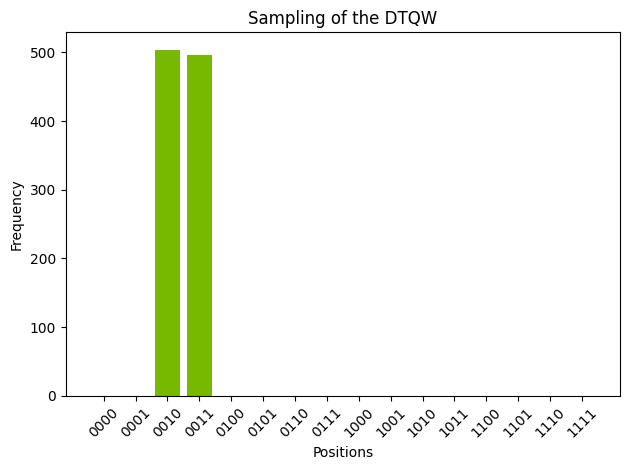

In [12]:
# EXERCISE 3
# Complete the code below to define S-
# S- will apply the DEC operation to the walker qubits
# when the coin qubit is in the |0> state

# Set the number of qubits
num_qubits = 4

@cudaq.kernel
def DTQW_one_step(num_qubits: int):
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qubit()
    endpoint_qubit = cudaq.qubit()

    # Initial walker state 1/(sqrt{2}) ( |2>+|3>)
    initial_position(walker_qubits)
        
    # Initial coin state    
    h(coin_qubit) #Comment to set the initial coin state to be |0>
        
    # One quantum walk step
    # Coin operation F=H
    h(coin_qubit)
    
    # Walker's position change 
    
    ## Shifting right
    
    # Avoid shifting from |1111> to |0000> in case the coin is |1> by flipping the coin to |0>
    no_INC_at_right_endpoint(walker_qubits, coin_qubit, endpoint_qubit)
    
    # Shift right (S+) when the coin is |1> and the walker is not in the |1111> state
    INC.ctrl(coin_qubit, walker_qubits[0], walker_qubits[1], walker_qubits[2], walker_qubits[3])

    # Reset the coin and endpoints in case they were changed to avoid moving from |1111> to |0000>
    reset_coin_and_endpoint(coin_qubit, endpoint_qubit)
    
    ## Shifting left
    
    # Avoid shifting from |0000> to |1111> in case the coin is |0> by flipping the coin to |1>
    no_DEC_at_left_endpoint(walker_qubits, coin_qubit, endpoint_qubit)
    
    # Shift left (S-) when the coin is |0>
    # EDIT CODE BELOW THIS LINE
    


    
    # EDIT CODE ABOVE THIS LINE
    
    # Reset the coin and endpoints in case they were changed to avoid moving from |0000> to |1111>
    reset_coin_and_endpoint(coin_qubit, endpoint_qubit)
    
    mz(walker_qubits)

# Visualize the kernel for the quantum walk
#print(cudaq.draw(DTQW_one_step, num_qubits))

# Sample the kernel for the quantum walk
result = cudaq.sample(DTQW_one_step, num_qubits, shots_count=1000)
print(result)
plot_results(result, num_qubits)

Does the output match what you expect?  Experiment with different initial states of the coin and walker qubits and different coin operators.

In the next notebook, [Quantum Walks for Finance Part 2: Learnable Quantum Walk in Financial Simulation](https://github.com/NVIDIA/cuda-q-academic/quantum-applications-to-finance/02_quantum_walks.ipynb), we'll extend this idea allowing for parameterized coinflip operations, and introduce the idea of a split step.  These will allow us to generate more interesting probability distributions than what we can do with the DTQW, which may better model financial data.  